In [112]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

In [113]:
#importing data
BL = pd.read_csv('Data/BankLend.csv')
consumption = pd.read_csv('Data/consumption.csv')
gdp_exp = pd.read_csv('Data/gdp.csv')
housing_starts = pd.read_csv('Data/HousingStarts.csv')
ex_rate = pd.read_csv('Data/CEER_MONTHLY_NOMINAL-sd-1990-01-01.csv') #Canadian Effective Exchange Rate - monthly nominal
SP_tbills = pd.read_csv('Data/s&p, tbills.csv')
house_prices = pd.read_csv('Data/OECD Data.csv')

In [114]:
# BANK LENDING

# Summing over rows of 3 to get quarterly data
def sum_quarter(group):
    return pd.Series({'ReferencePeriod': group['ReferencePeriod'].iloc[0],
                      'Total, funds advanced, residential mortgages, insured 7': group['Total, funds advanced, residential mortgages, insured 7'].sum(),
                      'Total, funds advanced, residential mortgages, uninsured 7': group['Total, funds advanced, residential mortgages, uninsured 7'].sum(),
                      'Total, funds advanced, variable rate mortgages': group['Total, funds advanced, variable rate mortgages'].sum(),
                      'Total, funds advanced for non-mortgage loans, consumer credit': group['Total, funds advanced for non-mortgage loans, consumer credit'].sum(),
                      'Total, funds advanced, business loans 8': group['Total, funds advanced, business loans 8'].sum()})

# Group by sets of 3 rows and average using the custom function
BankLend = BL.groupby(BL.index // 3).apply(sum_quarter)
BankLend['ReferencePeriod'] = pd.to_datetime(BankLend['ReferencePeriod'])
BankLend['Quarters'] = BankLend['ReferencePeriod'].dt.to_period("Q").astype(str)

# cleaning up the data
BankLend['BankLending'] = BankLend['Total, funds advanced, residential mortgages, insured 7'] + BankLend['Total, funds advanced, residential mortgages, uninsured 7'] +  BankLend['Total, funds advanced, variable rate mortgages'] + BankLend['Total, funds advanced for non-mortgage loans, consumer credit'] + BankLend['Total, funds advanced, business loans 8'] + BankLend['Total, funds advanced, business loans 8']
BankLend1 = BankLend[['Quarters','BankLending']]
BankLend1.head()

,Quarters,BankLending
0,2013Q1,382924.0
1,2013Q2,493784.0
2,2013Q3,483018.0
3,2013Q4,503383.0
4,2014Q1,420139.0


In [115]:
# GDP 

# keeping specific columns
gdp = gdp_exp[['Quarters', 'Gross domestic product at market prices']]

gdp.head()

,Quarters,Gross domestic product at market prices
0,2000Q1,1514676
1,2000Q2,1532503
2,2000Q3,1548212
3,2000Q4,1551274
4,2001Q1,1560006


In [116]:
# EXCHANGE RATE

# keeping one column
filtered_ex_rate = ex_rate[['date','CEER_BROADNM']]
filtered_ceer = filtered_ex_rate.reset_index(drop=True)

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'date': group['date'].iloc[0],
                      'CEER_BROADNM': group['CEER_BROADNM'].mean()})

# Group by sets of 3 rows and average using the custom function
ceer = filtered_ceer.groupby(filtered_ceer.index // 3).apply(average_quarter).reset_index(drop=True)

# converting date to datetime format
ceer['date'] = pd.to_datetime(ceer['date'])
ceer['Quarters'] = ceer['date'].dt.to_period("Q").astype(str)

ceer = ceer.drop(['date'], axis=1)
ceer.head()

,CEER_BROADNM,Quarters
0,98.053333,1999Q1
1,101.366667,1999Q2
2,100.096667,1999Q3
3,100.486667,1999Q4
4,102.433333,2000Q1


In [117]:
# CONSUMPTION, HOUSE PRICES, HOUSING STARTS

print(consumption.head())
print(house_prices.head())
print(housing_starts.head())

  Quarters  Household final consumption expenditure
0   2000Q1                                   143884
1   2000Q2                                   145903
2   2000Q3                                   148957
3   2000Q4                                   150284
4   2001Q1                                   151594
  Quarters  House_Prices
0   2001Q1     40.844646
1   2001Q2     41.200980
2   2001Q3     41.875943
3   2001Q4     42.620664
4   2002Q1     43.340875
  Quarters  HousingStarts
0   2016Q1          38175
1   2016Q2          53286
2   2016Q3          54899
3   2016Q4          51555
4   2017Q1          42862


In [118]:
# FINANCIAL INDICATORS: S&P 500, T-BILLS

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'nummonth': group['nummonth'].iloc[0],
                      'sp': group['sp'].mean(), 't_bills': group['t_bills'].mean()})

# Group by sets of 3 rows and average using the custom function
fin_ind = SP_tbills.groupby(SP_tbills.index // 3).apply(average_quarter).reset_index(drop=True)
fin_ind.rename(columns={'nummonth': 'Quarters'}, inplace=True)
fin_ind.head()

,Quarters,sp,t_bills
0,2013Q1,36782.440000,0.953333
1,2013Q2,36089.766667,1.010000
2,2013Q3,37059.500000,0.990000
3,2013Q4,39750.513333,0.916667
4,2014Q1,41900.943333,0.876667


In [119]:
merge1 = pd.merge(gdp, consumption, on = 'Quarters')
merge2 = pd.merge(merge1, BankLend1, on = 'Quarters')
merge3 = pd.merge(merge2, ceer, on = 'Quarters')
merge4 = pd.merge(merge3, house_prices, on = 'Quarters')
merge5 = pd.merge(merge4, housing_starts, on = 'Quarters')
final_df = pd.merge(merge5, fin_ind, on = 'Quarters')
final_df.head()
final_df.dtypes

Quarters                                    object
Gross domestic product at market prices      int64
Household final consumption expenditure      int64
BankLending                                float64
CEER_BROADNM                               float64
House_Prices                               float64
HousingStarts                                int64
sp                                         float64
t_bills                                    float64
dtype: object

In [120]:
final_df['Quarters'] = pd.to_datetime(final_df['Quarters'])
final_df.head()
final_df.dtypes

# Convert to float
final_df['Gross domestic product at market prices'] = final_df['Gross domestic product at market prices'].astype(int)

# Convert to int
final_df['HousingStarts'] = final_df['HousingStarts'].astype(int)

final_df.dtypes

Quarters                                   datetime64[ns]
Gross domestic product at market prices             int64
Household final consumption expenditure             int64
BankLending                                       float64
CEER_BROADNM                                      float64
House_Prices                                      float64
HousingStarts                                       int64
sp                                                float64
t_bills                                           float64
dtype: object

In [121]:
import numpy as np
from statsmodels.tsa.vector_ar.svar_model import SVAR

# Assuming your data is in a DataFrame named 'final_df'
# If not, replace 'final_df' with your actual DataFrame

# Convert DataFrame to NumPy array
endog_data = final_df[['Gross domestic product at market prices', 'Household final consumption expenditure', 'BankLending', 'CEER_BROADNM', 'House_Prices', 'HousingStarts', 'sp', 't_bills']].to_numpy()

# Impose Short-Term Restrictions for SVAR
B_matrix = np.array([
    [1, 'E', 'E', 0, 0, 0, 0, 0],
    [0, 1, 0, 'E', 'E', 'E', 0, 'E'],
    [0, 0, 1, 'E', 0,'E', 0, 'E'],
    [0, 0, 0, 1, 'E', 'E', 0, 'E'],
    [0, 0, 0, 0, 1, 'E', 'E', 'E'],
    [0, 0, 0, 0, 0, 1, 'E', 'E'],
    [0, 0, 0, 0, 0, 0, 1, 'E'],
    [0, 0, 0, 0, 0, 0, 0, 1],
])

# Define SVAR Model
svar_model = SVAR(endog=endog_data, svar_type='B', A=None, B=B_matrix, dates=final_df['Quarters'])

/Users/anahat/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


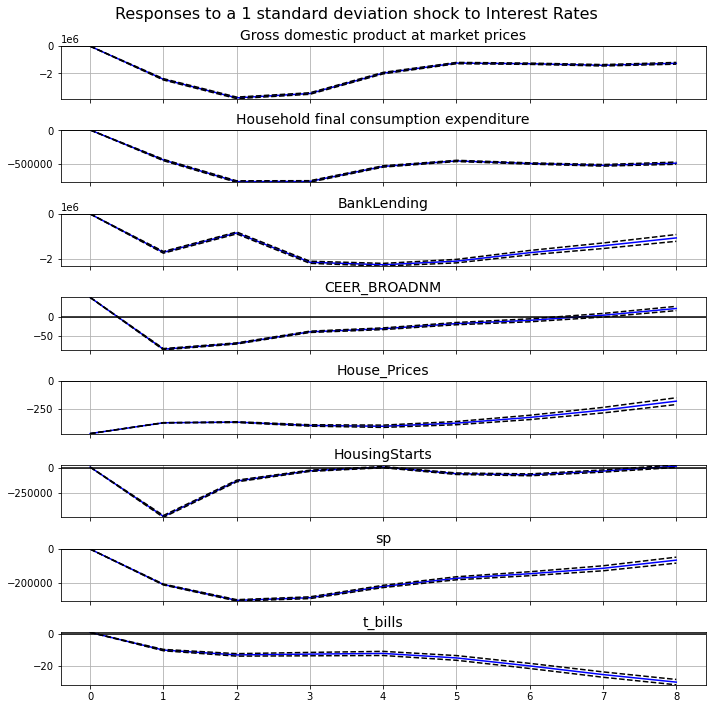

In [136]:
import matplotlib.pyplot as plt

# Get the list of variable names in the model
var_names = ['Gross domestic product at market prices', 'Household final consumption expenditure', 'BankLending', 'CEER_BROADNM', 'House_Prices', 'HousingStarts', 'sp', 't_bills']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('t_bills')

# Use this index for the impulse parameter
irf = result.irf(periods=8)

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Responses to a 1 standard deviation shock to Interest Rates', fontsize=16)

plt.tight_layout()
plt.show()

In [139]:
import pandas as pd
import numpy as np

# Get the IRFs as a numpy array
irfs_array = irf.irfs

# Create a MultiIndex for the DataFrame
index = pd.MultiIndex.from_product([range(irfs_array.shape[0]), var_names, var_names], names=['period', 'response', 'impulse'])

# Convert this array into a DataFrame
irfs_df = pd.DataFrame(irfs_array.flatten(), index=index, columns=['irf'])

# Select the 1st, 4th, and 8th quarters for 'tbills' impulse
selected_periods = irfs_df.loc[(slice(0,8,4), slice(None), 't_bills'), :]


# Reset the 'impulse' level of the index
selected_periods = selected_periods.reset_index(level='impulse', drop=True)

# Unstack the 'response' level of the index
reshaped_df = selected_periods.unstack(level='response')

# Print the reshaped DataFrame
print(reshaped_df)

                   irf                                                       \
response   BankLending CEER_BROADNM Gross domestic product at market prices   
period                                                                        
0             0.000000     0.000000                                0.000000   
4        -35283.580236    -2.249876                           -26344.067883   
8        -78722.949086    -2.353015                           -46947.215419   

                                                                             \
response House_Prices Household final consumption expenditure HousingStarts   
period                                                                        
0            0.000000                                0.000000      0.000000   
4           -8.506994                            -4223.929104  -4443.198347   
8          -16.160703                           -13967.529772  -5646.933090   

                                 
response        

In [142]:
import pandas as pd
import numpy as np

# Get the IRFs as a numpy array
irfs_array = irf.irfs

# Create a MultiIndex for the DataFrame
index = pd.MultiIndex.from_product([range(irfs_array.shape[0]), var_names, var_names], names=['period', 'response', 'impulse'])

# Convert this array into a DataFrame
irfs_df = pd.DataFrame(irfs_array.flatten(), index=index, columns=['irf'])

# Select the 1st, 4th, and 8th quarters for 'tbills' impulse
selected_periods = irfs_df.loc[(slice(0,8,4), slice(None), 't_bills'), :]

# Reset the 'impulse' level of the index
selected_periods = selected_periods.reset_index(level='impulse', drop=True)

# Unstack the 'response' level of the index
reshaped_df = selected_periods.unstack(level='response')

# Define the table styles
table_styles = [
    {'selector': 'th', 'props': [('color', 'blue')]}
]

# Apply the table styles to the DataFrame
styled_df = reshaped_df.style.set_table_styles(table_styles)

# Display the styled DataFrame
styled_df